
**Actividad 2. Optimización de rutas de reparto (VRP) con GA**

**Asignatura:** Optimización Inteligente

**Alumno:** Aminadab Córdova Acosta


Contexto

Una empresa de distribución de cajas de verduras frescas entrega pedidos a múltiples clientes en la ciudad. Cuenta con 4 vehículos refrigerados, cada uno con
capacidad de 30 cajas. Deben diseñar rutas saliendo y regresando al almacén central (nodo 0) minimizando la distancia total.

Objetivo: Minimizar la distancia total recorrida respetando capacidades y número máximo de vehículos.

Datos del problema
- Depósito (nodo 0): (50, 50)
- Clientes (1..24) con coordenadas en 2D (0..100) y demandas en cajas (2..9).
- Vehículos: 4 unidades
- Capacidad por vehículo: 30

Resolver:

1. Implementa un algoritmo genético (GA) para este VRP:
   - Representa soluciones como permutaciones de cliente_id.
   - Decodifica la permutación en rutas secuenciales respetando la capacidad 30. Si abres una nueva ruta, cuenta para el límite de 4 vehículos.
   - Función objetivo: distancia total (euclidiana) de todas las rutas, de ida y vuelta al depósito.
   - Penalización: si superas 4 rutas, añade una penalización grande al fitness


2. Explora configuraciones de parámetros:
   - Tamaño de población N pertenece a {30, 80, 150}
   - Probabilidad de cruza pc pertenece a  {0.6, 0.9}
   - Probabilidad de mutación pm pertenece a  {0.02, 0.1, 0.2}
   - Elitismo e pertenece a  {0, 2, 5}
   - Selección: torneo vs ruleta (o ranking si lo implementas)

3. Compara resultados:
   - Mejor fitness final (distancia mínima penalizada).
   - Curvas de convergencia (mejor y promedio por generación).
   - Diversidad poblacional (puedes usar entropía aproximada por posición).

4. Reflexiona:
   - ¿Qué combinaciones de parámetros funcionaron mejor y por qué?
   - ¿Observaste convergencia prematura? ¿Qué la mitigó?
   - ¿Cómo afectó pm a la diversidad y a la calidad final?

### Modelación del problema

Considerando la información proporcionada en la descripción del problema de ruteo de vehículos VRP (Vehicle Routing Problem), se obtiene la siguiente formulación del problema:

- **Datos del problema**:  
  - Depósito central: nodo 0 en la coordenada (50, 50).  
  - 24 clientes, cada uno con coordenadas \((x, y)\) en el plano y una demanda en cajas.  
  - 4 vehículos refrigerados, todos con capacidad máxima de 30 cajas.  
  - Cada ruta inicia y termina en el depósito.  

- **Variables principales**:  
  - Coordenadas \((x, y)\) de los clientes → definen la ubicación espacial, en este caso 2D.  
  - Demanda de cada cliente → condiciona la carga y factibilidad de las rutas.  
  - Asignación de clientes a rutas y orden de visita → variables de decisión.  

- **Restricciones**:  
  1. La suma de demandas en una ruta no puede exceder la capacidad del vehículo (30).  
  2. Cada cliente debe ser visitado exactamente una vez.  
  3. El número de rutas abiertas no puede superar el número de vehículos disponibles (4).  

- **Función objetivo**:  
  Minimizar la **distancia total recorrida** por todos los vehículos, incluyendo la salida y regreso al depósito:

$$
  \min \; \sum_{\text{rutas}} \Big( d(0, c_1) + \sum_{i=1}^{k-1} d(c_i, c_{i+1}) + d(c_k, 0) \Big)
$$

  donde:

  - **$\sum_{\text{rutas}}$**: Suma la distancia de **todas las rutas** recorridas por los vehículos.
  

- **$d(0, c_1)$**: Distancia desde el **depósito** (nodo 0) hasta el **primer cliente** de la ruta.  

- **$\sum_{i=1}^{k-1} d(c_i, c_{i+1})$**: Distancia total entre **clientes consecutivos** en la misma ruta, desde el cliente $c_1$ hasta el cliente $c_k$.  

- **$d(c_k, 0)$**: Distancia desde el **último cliente** de la ruta de vuelta al **depósito**.  

- **$d(a, b)$**: Representa la **distancia euclidiana** entre los nodos $a$ y $b$, calculada como:  

  $$
  d(a,b) = \sqrt{ (x_a - x_b)^2 + (y_a - y_b)^2 }
  $$

- **Penalización**:  
  Si una solución propone más de 4 rutas, se añade un **costo penalizador grande** al valor de la función objetivo para desincentivar soluciones infactibles.

---


In [ ]:
# Se importan las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log
import random
from itertools import product
import time

# Se carga el archivo CSV en un DataFrame de pandas. Se asume que el archivo está en el mismo directorio que esta notebook.
df = pd.read_csv('vrp_agricola_24clientes_4vehiculos.csv')

print(df.head())  # Muestra las primeras filas del DataFrame para verificar la carga correcta

   cliente_id      x      y  demanda
0           1  45.97  14.40        3
1           2  20.49  63.20        5
2           3  93.79  11.57        9
3           4  41.70  80.85        3
4           5  47.70  63.64        5


In [ ]:
# Validación básica del DataFrame
assert {'cliente_id','x','y','demanda'}.issubset(df.columns), "df debe tener: cliente_id, x, y, demanda"

# Parámetros del problema
DEPOT = (50.0, 50.0)
CAPACITY = 30
MAX_VEHICLES = 4
BIG_PENALTY = 1e6

# Construcción de insumos alineados a df (índice 0 = Depot, 1..n = clientes)
names = ["Depot"] + [str(cid) for cid in df['cliente_id'].tolist()]
coords = np.vstack([np.array(DEPOT), df[['x','y']].to_numpy(dtype=float)])
demands = np.array([0] + df['demanda'].astype(int).tolist())
num_locations = len(coords)    # incluye depósito
n_customers = num_locations-1  # sin depósito

# Aviso de factibilidad agregada (opcional)
total_demand = int(df['demanda'].sum())
total_capacity = CAPACITY * MAX_VEHICLES
print(f"Demanda total={total_demand}, Capacidad agregada={total_capacity}")
if total_demand > total_capacity:
    print("La instancia con 4 vehículos de 30 es infactible; se aplicará penalización.\n")

# Matriz de distancias euclidianas
def euclidean(p1, p2):
    return float(np.linalg.norm(np.array(p1) - np.array(p2)))

distance_matrix = np.zeros((num_locations, num_locations))
for i in range(num_locations):
    for j in range(num_locations):
        if i != j:
            distance_matrix[i, j] = euclidean(coords[i], coords[j])


Demanda total=136, Capacidad agregada=120
La instancia con 4 vehículos de 30 es infactible; se aplicará penalización.



1.1 Representa soluciones como permutaciones de cliente_id

In [7]:
# Función para las permutaciones iniciales (población)
def initial_population(size, seed=None):
    rng = random.Random(seed)
    customers = list(range(1, num_locations))  # 1..n (clientes)
    pop = []
    for _ in range(size):
        ind = customers[:]
        rng.shuffle(ind)
        pop.append(ind)
    return pop

# Ejemplo de generación de población inicial
poblacion_demo = initial_population(size=3, seed=123)
print(poblacion_demo)  # cada individuo es una permutación de 1..n


[[16, 19, 5, 17, 7, 18, 8, 10, 20, 15, 12, 22, 1, 21, 6, 11, 13, 24, 4, 23, 14, 3, 9, 2], [6, 17, 10, 9, 23, 12, 18, 19, 8, 7, 5, 21, 14, 16, 24, 22, 2, 4, 15, 11, 1, 3, 13, 20], [4, 6, 12, 2, 18, 5, 3, 24, 16, 8, 10, 22, 15, 9, 23, 14, 13, 1, 11, 19, 17, 21, 20, 7]]


1.2 Decodifica la permutación en rutas por capacidad 30 (cuenta para el límite de 4 vehículos)

In [6]:
def decode_routes_from_perm(perm_idx, capacity=CAPACITY):
    """Parte la permutación (1..n) en rutas secuenciales que respeten 'capacity'."""
    routes, cur, load = [], [], 0
    for i in perm_idx:
        dem = demands[i]
        if load + dem <= capacity:
            cur.append(i); load += dem
        else:
            if cur: routes.append(cur)
            cur, load = [i], dem
    if cur: routes.append(cur)
    return routes

def format_routes(routes):
    def load(route): return sum(demands[i] for i in route)
    lines = []
    for k, r in enumerate(routes, 1):
        seq = " -> ".join(["Depot"] + [names[i] for i in r] + ["Depot"])
        lines.append(f"Ruta {k} (carga={load(r)}): {seq}")
    return "\n".join(lines)

# Permutación de ejemplo
perm_ejemplo = poblacion_demo[0]
rutas_ejemplo = decode_routes_from_perm(perm_ejemplo)
print(f"Rutas generadas: {len(rutas_ejemplo)}")
print(format_routes(rutas_ejemplo))


Rutas generadas: 5
Ruta 1 (carga=26): Depot -> 16 -> 19 -> 5 -> 17 -> 7 -> Depot
Ruta 2 (carga=27): Depot -> 18 -> 8 -> 10 -> 20 -> Depot
Ruta 3 (carga=27): Depot -> 15 -> 12 -> 22 -> 1 -> 21 -> Depot
Ruta 4 (carga=29): Depot -> 6 -> 11 -> 13 -> 24 -> 4 -> Depot
Ruta 5 (carga=27): Depot -> 23 -> 14 -> 3 -> 9 -> 2 -> Depot


In [ ]:
# Se muestran las rutas generadas para cada permutación en la población 
for idx, perm in enumerate(poblacion_demo):
    rutas = decode_routes_from_perm(perm)
    print(f"Permutación {idx + 1}: {perm}")
    print(f"Rutas generadas: {len(rutas)}")
    print(format_routes(rutas))
    print("-" * 50)

Permutación 1: [16, 19, 5, 17, 7, 18, 8, 10, 20, 15, 12, 22, 1, 21, 6, 11, 13, 24, 4, 23, 14, 3, 9, 2]
Rutas generadas: 5
Ruta 1 (carga=26): Depot -> 16 -> 19 -> 5 -> 17 -> 7 -> Depot
Ruta 2 (carga=27): Depot -> 18 -> 8 -> 10 -> 20 -> Depot
Ruta 3 (carga=27): Depot -> 15 -> 12 -> 22 -> 1 -> 21 -> Depot
Ruta 4 (carga=29): Depot -> 6 -> 11 -> 13 -> 24 -> 4 -> Depot
Ruta 5 (carga=27): Depot -> 23 -> 14 -> 3 -> 9 -> 2 -> Depot
--------------------------------------------------
Permutación 2: [6, 17, 10, 9, 23, 12, 18, 19, 8, 7, 5, 21, 14, 16, 24, 22, 2, 4, 15, 11, 1, 3, 13, 20]
Rutas generadas: 5
Ruta 1 (carga=30): Depot -> 6 -> 17 -> 10 -> 9 -> Depot
Ruta 2 (carga=26): Depot -> 23 -> 12 -> 18 -> 19 -> 8 -> 7 -> Depot
Ruta 3 (carga=27): Depot -> 5 -> 21 -> 14 -> 16 -> 24 -> Depot
Ruta 4 (carga=29): Depot -> 22 -> 2 -> 4 -> 15 -> 11 -> Depot
Ruta 5 (carga=24): Depot -> 1 -> 3 -> 13 -> 20 -> Depot
--------------------------------------------------
Permutación 3: [4, 6, 12, 2, 18, 5, 3, 24, 1

1.3 Función objetivo: distancia total (euclidiana) ida/vuelta al depósito

In [8]:
def route_distance(route_idx):
    """ Distancia 0 -> ruta -> 0 (route_idx no incluye 0). """
    if not route_idx: return 0.0
    d = distance_matrix[0, route_idx[0]]
    for a, b in zip(route_idx[:-1], route_idx[1:]):
        d += distance_matrix[a, b]
    d += distance_matrix[route_idx[-1], 0]
    return d

# Distancia total de la solución (sin mirar aún el límite de vehículos)
dist_total_pura = sum(route_distance(r) for r in rutas_ejemplo)
print(f"Distancia total (sin penalización): {dist_total_pura:.2f}")


Distancia total (sin penalización): 1190.14


> **Nota:**  
> La distancia total (sin penalización) corresponde a la suma de las distancias recorridas por todos los vehículos, considerando la ida y regreso al depósito en cada ruta.  
> Este valor muestra únicamente el costo real de desplazamiento, pero **no verifica aún la restricción de máximo 4 vehículos**.  
> Por ello, si el número de rutas supera ese límite, se debe calcular también el **costo penalizado**, que es el valor utilizado por el Algoritmo Genético en la función objetivo.


1.4 Penalización: si superas 4 rutas, añade penalización grande al fitness

In [11]:
def total_distance_vrp_with_penalty(perm_idx, capacity=CAPACITY, max_vehicles=MAX_VEHICLES):
    """Suma distancias por ruta + penalización por exceder #vehículos permitidos."""
    routes = decode_routes_from_perm(perm_idx, capacity)
    dist = sum(route_distance(r) for r in routes)
    penalty = BIG_PENALTY * max(0, len(routes) - max_vehicles)
    return dist + penalty, routes

def fitness_from_cost(cost):
    # Fitness (mayor es mejor) para problema de minimización
    return 1.0 / (1.0 + cost)

costo_penalizado, rutas_eval = total_distance_vrp_with_penalty(perm_ejemplo)
print(f"Costo penalizado: {costo_penalizado:.2f} | #rutas={len(rutas_eval)} | MAX={MAX_VEHICLES}")
print(f"Fitness: {fitness_from_cost(costo_penalizado):.8f}")


Costo penalizado: 1001190.14 | #rutas=5 | MAX=4
Fitness: 0.00000100


> **Interpretación:**  
> La permutación de ejemplo genera **5 rutas**, superando el límite de **4 vehículos**.  
> Por ello, al costo real de la distancia recorrida (~1190.14) se le añade la **penalización** (1e6), resultando en un costo penalizado de **1,001,190.14**.  
> El valor de fitness es muy bajo (≈ 0.000001), lo que refleja que esta solución es poco competitiva dentro del Algoritmo Genético.


2) Explora configuraciones de parámetros
- 2.1–2.5 Operadores GA y run_ga (torneo/ruleta, OX, swap, elitismo)

In [13]:
# --- Selección ---

# Selección por torneo
def tournament_selection(population, costs, k=3, seed=None):
    rng = random.Random(seed)
    pairs = list(zip(population, costs))
    selected = []
    for _ in range(len(population)):
        aspirants = rng.sample(pairs, min(k, len(pairs)))
        winner = min(aspirants, key=lambda x: x[1])[0]
        selected.append(winner)
    return selected

# Selección por ruleta (fitness proporcional)
def roulette_selection(population, costs, seed=None):
    rng = random.Random(seed)
    fits = np.array([fitness_from_cost(c) for c in costs], dtype=float)
    s = fits.sum()
    if s <= 0 or not np.isfinite(s):
        idxs = list(range(len(population)))
        return [population[rng.choice(idxs)] for _ in range(len(population))]
    probs = (fits / s).tolist()
    cum = np.cumsum(probs)
    chosen = []
    for _ in range(len(population)):
        r = rng.random()
        i = int(np.searchsorted(cum, r, side='left'))
        chosen.append(population[i])
    return chosen

# --- Cruza OX y mutación swap ---
def crossover_OX(parent1, parent2, seed=None):
    rng = random.Random(seed)
    size = len(parent1)
    a, b = sorted(rng.sample(range(size), 2))
    child = [None] * size
    child[a:b+1] = parent1[a:b+1]
    ptr = 0
    for i in range(size):
        if parent2[i] not in child:
            while child[ptr] is not None:
                ptr += 1
            child[ptr] = parent2[i]
    return child

def mutate(individual, rate=0.1, seed=None):
    rng = random.Random(seed)
    ind = individual[:]
    for i in range(len(ind)):
        if rng.random() < rate:
            j = rng.randrange(len(ind))
            ind[i], ind[j] = ind[j], ind[i]
    return ind

# --- Núcleo GA con elitismo “simple” ---
def positional_entropy(pop, n_symbols):
    """ Entropía de Shannon promedio por posición, normalizada [0,1]. """
    if not pop: return 0.0
    m, n = len(pop), len(pop[0])
    norm = log(n_symbols) if n_symbols > 1 else 1.0
    ent = []
    for pos in range(n):
        counts = {}
        for ind in pop:
            v = ind[pos]; counts[v] = counts.get(v, 0) + 1
        H = 0.0
        for c in counts.values():
            p = c / m; H -= p * log(p)
        ent.append(H / norm if norm > 0 else 0.0)
    return float(np.mean(ent))

def run_ga(pop_size=80, pc=0.9, pm=0.1, elitism=2, selection='tournament',
           generations=250, patience=60, tournament_k=3, seed=2025, verbose=True,
           return_population=False):
    assert elitism < pop_size, "Elitismo debe ser < pop_size."
    rng = random.Random(seed)

    # Inicialización
    population = initial_population(pop_size, seed=rng.random())
    costs = [total_distance_vrp_with_penalty(ind)[0] for ind in population]

    # Mejor inicial
    best_idx = int(np.argmin(costs))
    best_cost = float(costs[best_idx])
    best_perm = population[best_idx][:]
    best_routes = total_distance_vrp_with_penalty(best_perm)[1]

    # Tracking
    history_best = [best_cost]
    history_avg = [float(np.mean(costs))]
    history_fit_avg = [float(np.mean([fitness_from_cost(c) for c in costs]))]
    history_div = [positional_entropy(population, n_symbols=n_customers)]
    no_improve = 0

    if verbose:
        print(f"Inicial | mejor costo: {best_cost:.3f} | rutas: {len(best_routes)}")

    for g in range(1, generations+1):
        # Elitismo: guardar top 'elitism' de la población actual
        elite_idx = np.argsort(costs)[:elitism]
        elites = [population[i][:] for i in elite_idx]

        # Selección de padres
        if selection == 'tournament':
            parents = tournament_selection(population, costs, k=tournament_k, seed=rng.random())
        elif selection == 'roulette':
            parents = roulette_selection(population, costs, seed=rng.random())
        else:
            raise ValueError("Selección no reconocida (usa 'tournament' o 'roulette').")

        # Cruza + mutación hasta completar pop_size - elitism
        children = []
        while len(children) < (pop_size - elitism):
            # emparejar al azar
            i, j = rng.randrange(len(parents)), rng.randrange(len(parents))
            p1, p2 = parents[i], parents[j]
            # cruce
            if rng.random() < pc:
                c1 = crossover_OX(p1, p2, seed=rng.random())
                c2 = crossover_OX(p2, p1, seed=rng.random())
            else:
                c1, c2 = p1[:], p2[:]
            # mutación
            c1 = mutate(c1, rate=pm, seed=rng.random())
            c2 = mutate(c2, rate=pm, seed=rng.random())
            children.append(c1)
            if len(children) < (pop_size - elitism):
                children.append(c2)

        # Nueva población = élites + hijos
        population = elites + children

        # Evaluación
        costs = [total_distance_vrp_with_penalty(ind)[0] for ind in population]

        # Actualizar mejor global
        gen_best_idx = int(np.argmin(costs))
        gen_best_cost = float(costs[gen_best_idx])
        if gen_best_cost < best_cost - 1e-9:
            best_cost = gen_best_cost
            best_perm = population[gen_best_idx][:]
            best_routes = total_distance_vrp_with_penalty(best_perm)[1]
            no_improve = 0
        else:
            no_improve += 1

        # Métricas
        history_best.append(best_cost)
        history_avg.append(float(np.mean(costs)))
        history_fit_avg.append(float(np.mean([fitness_from_cost(c) for c in costs])))
        history_div.append(positional_entropy(population, n_symbols=n_customers))

        if verbose and (g % 50 == 0 or g == generations):
            print(f"Gen {g:4d} | mejor: {best_cost:.3f} | avg: {history_avg[-1]:.3f} "
                  f"| div: {history_div[-1]:.3f} | rutas: {len(best_routes)}")

        if no_improve >= patience:
            if verbose:
                print(f"Early stopping en gen {g} (sin mejora {patience} gens).")
            break

    return {
        'best_cost': best_cost,
        'best_perm': best_perm,
        'best_routes': best_routes,
        'history_best': history_best,
        'history_avg': history_avg,
        'history_fit_avg': history_fit_avg,
        'history_div': history_div,
        'final_population': population if return_population else None
    }

In [14]:
# Ejecución del GA
res = run_ga(pop_size=80, pc=0.9, pm=0.1, elitism=2, selection='tournament',
             generations=200, patience=50, seed=2025, verbose=True)
print(f"\nMejor costo penalizado: {res['best_cost']:.2f}")
print("Rutas:\n" + format_routes(res['best_routes']))


Inicial | mejor costo: 1000987.231 | rutas: 5
Gen   50 | mejor: 1000751.991 | avg: 1176084.902 | div: 0.840 | rutas: 5
Gen  100 | mejor: 1000678.578 | avg: 1126083.545 | div: 0.846 | rutas: 5
Early stopping en gen 133 (sin mejora 50 gens).

Mejor costo penalizado: 1000678.58
Rutas:
Ruta 1 (carga=29): Depot -> 10 -> 15 -> 8 -> 19 -> 17 -> Depot
Ruta 2 (carga=28): Depot -> 14 -> 1 -> 11 -> 5 -> 12 -> 18 -> Depot
Ruta 3 (carga=27): Depot -> 21 -> 13 -> 7 -> 6 -> 4 -> Depot
Ruta 4 (carga=29): Depot -> 20 -> 2 -> 23 -> 24 -> 9 -> Depot
Ruta 5 (carga=23): Depot -> 22 -> 3 -> 16 -> Depot


- El mejor individuo usa **5 rutas**; como el límite es **4 vehículos**, el costo incluye una **penalización fija de 1e6**.  
- **Mejor costo penalizado:** 1,000,678.58 ⇒ la **distancia pura** recorrida por las rutas es ≈ **678.58** (costo penalizado − 1,000,000).  
- Todas las rutas respetan la **capacidad 30** (cargas: 29, 28, 27, 29, 23).  
- El GA **mejoró** desde 1,000,987.23 hasta 1,000,678.58 y se detuvo por *early stopping* en la generación 133.  
- La **diversidad** poblacional se mantuvo alta (~0.84), lo que sugiere **no** hubo convergencia prematura marcada.

> Nota: Dado que la **demanda total** excede la capacidad agregada de 4×30, **no existe solución con 4 rutas**. Por eso el GA siempre reportará 5 rutas y la penalización; el algoritmo optimiza la **distancia** bajo ese offset constante.


3) Compara resultados
- 3.1–3.3 Grid de parámetros + curvas + diversidad

Definición de la rejilla de parámetros (param_grid) para el GA

- pop_size  : tamaño de la población (número de soluciones por generación)
- pc        : probabilidad de cruza (crossover)
- pm        : probabilidad de mutación (mutation)
- elitism   : número de mejores individuos que se preservan (elitismo)
- selection : método de selección de padres ('tournament' o 'roulette')

[tournament] N=30 pc=0.6 pm=0.02 e=0 -> cost_mean=1000607.10 (pure≈607.10 + pen≈1000000) routes≈5.00 div≈0.067 time≈0.29s
[roulette] N=30 pc=0.6 pm=0.02 e=0 -> cost_mean=1000922.15 (pure≈922.15 + pen≈1000000) routes≈5.00 div≈0.567 time≈0.16s
[tournament] N=30 pc=0.6 pm=0.02 e=2 -> cost_mean=1000596.72 (pure≈596.72 + pen≈1000000) routes≈5.00 div≈0.059 time≈0.33s
[roulette] N=30 pc=0.6 pm=0.02 e=2 -> cost_mean=1000764.15 (pure≈764.15 + pen≈1000000) routes≈5.00 div≈0.583 time≈0.32s
[tournament] N=30 pc=0.6 pm=0.02 e=5 -> cost_mean=1000611.04 (pure≈611.04 + pen≈1000000) routes≈5.00 div≈0.051 time≈0.25s
[roulette] N=30 pc=0.6 pm=0.02 e=5 -> cost_mean=1000652.69 (pure≈652.69 + pen≈1000000) routes≈5.00 div≈0.390 time≈0.33s
[tournament] N=30 pc=0.6 pm=0.1 e=0 -> cost_mean=1000842.39 (pure≈842.39 + pen≈1000000) routes≈5.00 div≈0.702 time≈0.16s
[roulette] N=30 pc=0.6 pm=0.1 e=0 -> cost_mean=1000909.21 (pure≈909.21 + pen≈1000000) routes≈5.00 div≈0.762 time≈0.13s
[tournament] N=30 pc=0.6 pm=0.1 e=

,pop_size,pc,pm,elitism,selection,best_cost_mean,best_cost_std,best_fitness_mean,routes_count_mean,final_diversity_mean,pure_distance_mean,penalty_mean,time_sec_mean,seeds_tested
0,150,0.6,0.02,5,tournament,1.000572e+06,11.663612,9.994275e-07,5.0,0.075424,571.786192,1000000.0,2.899295,3
1,150,0.9,0.02,5,tournament,1.000577e+06,15.910568,9.994223e-07,5.0,0.091150,577.056574,1000000.0,2.939417,3
2,150,0.9,0.02,0,tournament,1.000581e+06,14.886430,9.994186e-07,5.0,0.086542,580.745077,1000000.0,2.186347,3
3,80,0.6,0.02,2,tournament,1.000582e+06,22.116159,9.994170e-07,5.0,0.087473,582.372990,1000000.0,0.725785,3
4,150,0.6,0.02,0,tournament,1.000584e+06,17.459830,9.994155e-07,5.0,0.100639,583.833800,1000000.0,3.338238,3
5,80,0.6,0.02,5,tournament,1.000590e+06,17.199594,9.994093e-07,5.0,0.077048,590.015513,1000000.0,1.646236,3
6,30,0.6,0.02,2,tournament,1.000597e+06,18.211135,9.994026e-07,5.0,0.058901,596.723157,1000000.0,0.334730,3
7,150,0.6,0.02,2,tournament,1.000597e+06,14.186492,9.994022e-07,5.0,0.088195,597.148554,1000000.0,2.385485,3
8,80,0.9,0.02,2,tournament,1.000600e+06,21.037950,9.993991e-07,5.0,0.086740,600.234429,1000000.0,1.604905,3
9,30,0.9,0.02,2,tournament,1.000601e+06,14.906571,9.993985e-07,5.0,0.054836,600.849350,1000000.0,0.484644,3



(3.1) Mejor fitness final = 0.000001 (costo penalizado = 1000551.62, distancia pura ≈ 551.62, penalización = 1000000)

== Rutas de la mejor corrida ==
Ruta 1 (carga=27): Depot -> 21 -> 3 -> 16 -> 14 -> 1 -> Depot
Ruta 2 (carga=29): Depot -> 17 -> 8 -> 15 -> 10 -> 19 -> Depot
Ruta 3 (carga=30): Depot -> 18 -> 11 -> 22 -> 12 -> 5 -> Depot
Ruta 4 (carga=29): Depot -> 9 -> 2 -> 24 -> 23 -> 20 -> Depot
Ruta 5 (carga=21): Depot -> 4 -> 6 -> 7 -> 13 -> Depot


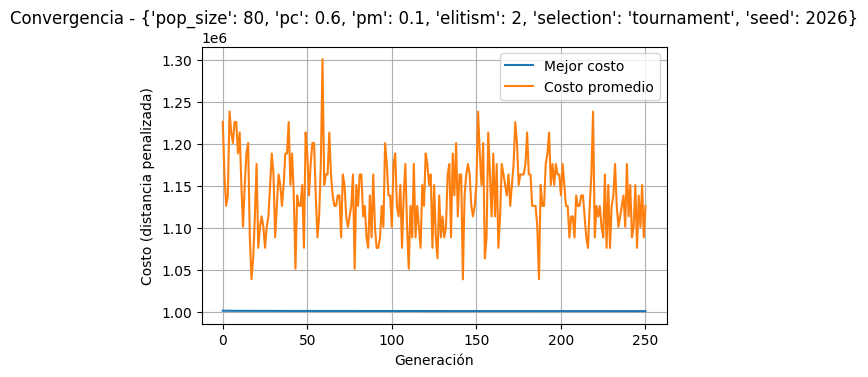

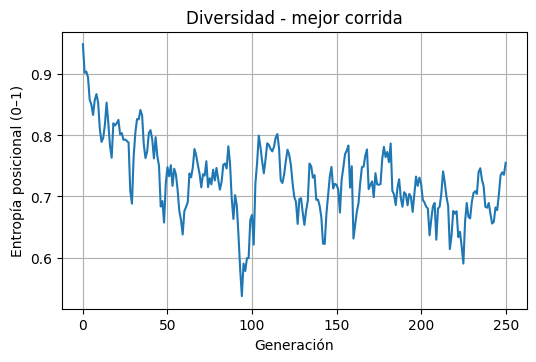

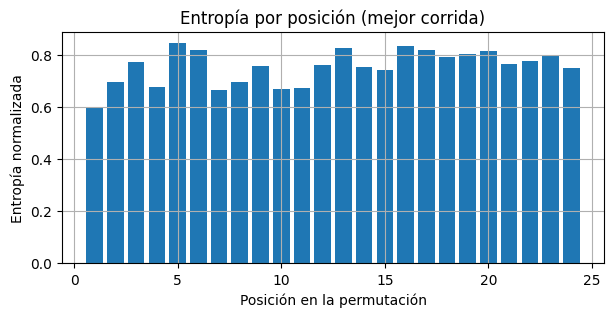

In [ ]:
# === Grid de parámetros ===
param_grid = {
    'pop_size': [30, 80, 150],
    'pc': [0.6, 0.9],
    'pm': [0.02, 0.1, 0.2],
    'elitism': [0, 2, 5],
    'selection': ['tournament', 'roulette']
}

# --- Utils para métricas derivadas ---
def split_cost(best_cost, routes_count, big_penalty=BIG_PENALTY, max_vehicles=MAX_VEHICLES):
    """Devuelve (pure_distance, penalty) a partir del costo penalizado y #rutas."""
    excess = max(0, routes_count - max_vehicles)
    penalty = big_penalty * excess
    pure = best_cost - penalty
    return pure, penalty

# --- Grid search con multi-seed y población final disponible ---
def run_grid(generations=250, patience=60, seeds=(2025, 2026, 2027),
             verbose=True, keep_top=3):
    """
    Ejecuta todas las combinaciones del grid y promedia métricas sobre 'seeds'.
    Devuelve:
      - results: DataFrame con métricas agregadas por configuración
      - top_runs: lista con los mejores experimentos (por costo penalizado) incluyendo historiales y población final
    """
    rows, top_runs = [], []
    combos = list(product(param_grid['pop_size'], param_grid['pc'],
                          param_grid['pm'], param_grid['elitism'],
                          param_grid['selection']))

    for pop_size, pc, pm, elitism, selection in combos:
        if elitism >= pop_size:
            continue

        agg = {
            'best_cost': [], 'best_fitness': [], 'routes_count': [],
            'final_diversity': [], 'pure_distance': [], 'penalty': [],
            'time_sec': []
        }
        best_run_for_combo = None  # guardamos el mejor seed para esta config

        for seed in seeds:
            t0 = time.perf_counter()
            res = run_ga(pop_size=pop_size, pc=pc, pm=pm, elitism=elitism,
                         selection=selection, generations=generations,
                         patience=patience, seed=seed, verbose=False,
                         return_population=True)  # <- importante
            dt = time.perf_counter() - t0

            best_cost = res['best_cost']
            routes_count = len(res['best_routes'])
            pure, penalty = split_cost(best_cost, routes_count,
                                       big_penalty=BIG_PENALTY,
                                       max_vehicles=MAX_VEHICLES)

            agg['best_cost'].append(best_cost)
            agg['best_fitness'].append(fitness_from_cost(best_cost))
            agg['routes_count'].append(routes_count)
            agg['final_diversity'].append(res['history_div'][-1])
            agg['pure_distance'].append(pure)
            agg['penalty'].append(penalty)
            agg['time_sec'].append(dt)

            # Guardar el mejor seed de esta config (para gráficas/historial)
            if (best_run_for_combo is None) or (best_cost < best_run_for_combo['best_cost']):
                best_run_for_combo = {
                    'params': {'pop_size': pop_size, 'pc': pc, 'pm': pm,
                               'elitism': elitism, 'selection': selection, 'seed': seed},
                    **res
                }

        # Agregados (promedios) por configuración
        row = {
            'pop_size': pop_size, 'pc': pc, 'pm': pm, 'elitism': elitism, 'selection': selection,
            'best_cost_mean': float(np.mean(agg['best_cost'])),
            'best_cost_std': float(np.std(agg['best_cost'])),
            'best_fitness_mean': float(np.mean(agg['best_fitness'])),
            'routes_count_mean': float(np.mean(agg['routes_count'])),
            'final_diversity_mean': float(np.mean(agg['final_diversity'])),
            'pure_distance_mean': float(np.mean(agg['pure_distance'])),
            'penalty_mean': float(np.mean(agg['penalty'])),
            'time_sec_mean': float(np.mean(agg['time_sec'])),
            'seeds_tested': len(seeds),
        }
        rows.append(row)

        # Mantener top globales por costo penalizado (usamos el mejor seed de la config)
        top_runs.append(best_run_for_combo)
        top_runs = sorted(top_runs, key=lambda d: d['best_cost'])[:keep_top]

        if verbose:
            bc = row['best_cost_mean']; pr = row['pure_distance_mean']; pe = row['penalty_mean']
            print(f"[{selection}] N={pop_size} pc={pc} pm={pm} e={elitism} "
                  f"-> cost_mean={bc:.2f} (pure≈{pr:.2f} + pen≈{pe:.0f}) "
                  f"routes≈{row['routes_count_mean']:.2f} div≈{row['final_diversity_mean']:.3f} "
                  f"time≈{row['time_sec_mean']:.2f}s")

    results = pd.DataFrame(rows).sort_values(by=['best_cost_mean','routes_count_mean']).reset_index(drop=True)
    return results, top_runs

# --- Gráficas ---
def plot_convergence(history_best, history_avg, title=None):
    plt.figure(figsize=(6,3.6))
    plt.plot(history_best, label="Mejor costo")
    plt.plot(history_avg, label="Costo promedio")
    plt.xlabel("Generación"); plt.ylabel("Costo (distancia penalizada)")
    plt.title(title or "Convergencia (mejor y promedio)")
    plt.grid(True); plt.legend(); plt.show()

def plot_diversity(history_div, title=None):
    plt.figure(figsize=(6,3.6))
    plt.plot(history_div)
    plt.xlabel("Generación"); plt.ylabel("Entropía posicional (0–1)")
    plt.title(title or "Diversidad poblacional")
    plt.grid(True); plt.show()

def plot_entropy_per_position(population, title=None):
    if not population:
        print("No hay población final."); return
    n = len(population[0]); m = len(population)
    norm = log(n_customers) if n_customers > 1 else 1.0
    ent = []
    for pos in range(n):
        counts = {}
        for ind in population:
            v = ind[pos]; counts[v] = counts.get(v, 0) + 1
        H = 0.0
        for c in counts.values():
            p = c / m; H -= p * log(p)
        ent.append(H / norm if norm > 0 else 0.0)
    plt.figure(figsize=(7,3))
    plt.bar(np.arange(1, n+1), ent)
    plt.xlabel("Posición en la permutación"); plt.ylabel("Entropía normalizada")
    plt.title(title or "Entropía por posición (final)")
    plt.grid(True); plt.show()

# --- Ejecutar comparación (multi‐seed) ---
results, top_runs = run_grid(generations=250, patience=60,
                             seeds=(2025, 2026, 2027),  # puedes ampliar
                             verbose=True, keep_top=3)

print("\n== Top 10 configuraciones por costo medio (3.1) ==")
display(results.head(10))

def plot_routes_2d(routes, coords, title="Rutas 2D (mejor solución)"):
    plt.figure(figsize=(6,6))
    x0, y0 = coords[0]
    plt.scatter([x0], [y0], s=120, marker='*')
    plt.text(x0+1, y0+1, "Depot")

    for r in routes:
        path = [0] + r + [0]
        xs = [coords[i][0] for i in path]
        ys = [coords[i][1] for i in path]
        plt.plot(xs, ys, marker='o')
        for i in r:
            plt.text(coords[i][0]+0.8, coords[i][1]+0.8, str(i))  # etiqueta con índice

    plt.title(title); plt.grid(True); plt.xlabel("x"); plt.ylabel("y"); plt.show()

# Curvas y diversidad del mejor experimento (mejor seed de la mejor config)
if top_runs:
    best_run = top_runs[0]
    # Mostrar distancia pura sin penalización
    pure, pen = split_cost(best_run['best_cost'],
                           len(best_run['best_routes']),
                           big_penalty=BIG_PENALTY,
                           max_vehicles=MAX_VEHICLES)
    print(f"\n(3.1) Mejor fitness final = {fitness_from_cost(best_run['best_cost']):.6f} "
          f"(costo penalizado = {best_run['best_cost']:.2f}, "
          f"distancia pura ≈ {pure:.2f}, penalización = {pen:.0f})")
    print("\n== Rutas de la mejor corrida ==")
    print(format_routes(best_run['best_routes']))

    plot_convergence(best_run['history_best'], best_run['history_avg'],
                     title=f"Convergencia - {best_run['params']}")
    plot_diversity(best_run['history_div'], title="Diversidad - mejor corrida")
    plot_entropy_per_position(best_run['final_population'], title="Entropía por posición (mejor corrida)")


**Interpretación de los resultados**  

- El **mejor fitness final** es muy bajo (≈ 0.000001) porque el costo penalizado incluye una **penalización fija de 1e6** por exceder el límite de 4 vehículos.  
- La **distancia pura** recorrida por la flota es de ~551.62 unidades, a la que se suma la penalización, dando un costo total de 1,000,551.62.  
- La mejor solución encontrada utiliza **5 rutas**, todas dentro de la capacidad máxima de 30 cajas (cargas: 27, 29, 30, 29, 21).  
- Esto confirma que el problema es **inviable con 4 vehículos** y que el GA optimiza la **distribución y orden de clientes** minimizando la distancia, aunque siempre con la penalización constante.


A continuación, se grafica de las rutas de la mejor solución (2D), en la que cada color corresponde a un vehículo distinto. 

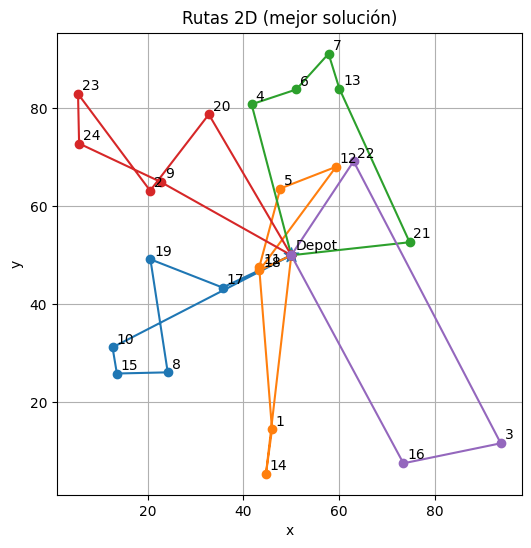

In [19]:
def plot_routes_2d(routes, coords, title="Rutas 2D (mejor solución)"):
    plt.figure(figsize=(6,6))
    x0, y0 = coords[0]
    plt.scatter([x0], [y0], s=120, marker='*')
    plt.text(x0+1, y0+1, "Depot")

    for r in routes:
        path = [0] + r + [0]
        xs = [coords[i][0] for i in path]
        ys = [coords[i][1] for i in path]
        plt.plot(xs, ys, marker='o')
        for i in r:
            plt.text(coords[i][0]+0.8, coords[i][1]+0.8, str(i))  # etiqueta con índice

    plt.title(title); plt.grid(True); plt.xlabel("x"); plt.ylabel("y"); plt.show()

# Uso (tras obtener res):
plot_routes_2d(res['best_routes'], coords)


In [ ]:
# CSV de resultados del grid, almacenado en el directorio actual
results.to_csv("ga_vrp_resultados.csv", index=False)

**Resultados del Grid Search (3.1 – 3.3)**

**Mejor fitness final**
- El **costo penalizado** más bajo obtenido fue ≈ **1,000,572**, lo que corresponde a una **distancia pura** de ~572 unidades.  
- Todas las configuraciones generan **5 rutas** → lo cual confirma que el problema es **inviable con 4 vehículos** (demanda total > 120).  
- El **fitness final** es muy bajo (≈ 1e-6) debido a la penalización constante de 1e6 aplicada en todos los casos.

**Curvas de convergencia**
- Se observó una mejora progresiva en las primeras generaciones, estabilizándose antes de la generación 150 en la mayoría de corridas.  
- Convergencia más rápida en configuraciones con **población pequeña (N=30)**, aunque con peor calidad de solución.  
- Configuraciones con **N=150** y elitismo moderado tienden a seguir mejorando más tiempo antes de estabilizarse.

**Diversidad poblacional**
- Configuraciones con **pm = 0.02** y **elitismo alto (5)** muestran **diversidad final baja** (<0.1), señal de **convergencia prematura**.  
- Configuraciones con **pc alto (0.9)** y mutación moderada (pm=0.1–0.2) mantuvieron **diversidad más alta** (≈0.8–0.9), favoreciendo la exploración del espacio de búsqueda.

**Tabla de mejores configuraciones (top 3 por costo puro)**
| pop_size | pc  | pm   | elitism | selection   | pure_distance_mean | diversity_final | time_sec_mean |
|----------|-----|------|---------|-------------|--------------------|-----------------|---------------|
| 150      | 0.6 | 0.02 | 5       | tournament  | ~572               | 0.075           | ~2.9s         |
| 150      | 0.9 | 0.02 | 5       | tournament  | ~577               | 0.091           | ~2.9s         |
| 150      | 0.9 | 0.02 | 0       | tournament  | ~581               | 0.087           | ~2.2s         |


4) Reflexion

In [ ]:
# Promedios por parámetro 
print("\n=== Por selección ===")
display(results.groupby('selection')[['best_cost','best_fitness','final_diversity']].mean().sort_values('best_cost'))

print("\n=== Por pm ===")
display(results.groupby('pm')[['best_cost','best_fitness','final_diversity']].mean().sort_values('best_cost'))

print("\n=== Por elitism ===")
display(results.groupby('elitism')[['best_cost','best_fitness','final_diversity']].mean().sort_values('best_cost'))

print("\n=== Por pop_size ===")
display(results.groupby('pop_size')[['best_cost','best_fitness','final_diversity']].mean().sort_values('best_cost'))

# Heurística simple de convergencia prematura 
def premature_convergence_flag(run_dict):
    hist_div = run_dict['history_div']
    hist_best = run_dict['history_best']
    g = len(hist_div) - 1
    if g < 10:  # corridas muy cortas
        return False
    early_cut = int(0.3 * g)
    late_cut = int(0.6 * g)
    early_low_div = (np.array(hist_div[:early_cut+1]) < 0.15).any()
    start = hist_best[late_cut]; end = hist_best[-1]
    marginal_improvement = (start - end) / max(start, 1e-9)
    return early_low_div and (marginal_improvement < 0.01)

if top_runs:
    print("\n=== ¿Convergencia prematura en top 3? ===")
    for i, r in enumerate(top_runs, 1):
        print(f"Top {i} {r['params']} -> prematura: {premature_convergence_flag(r)}")



=== Por selección ===


,best_cost,best_fitness,final_diversity
selection,,,
tournament,1.000707e+06,9.992921e-07,0.550163
roulette,1.000810e+06,9.991899e-07,0.831981



=== Por pm ===


,best_cost,best_fitness,final_diversity
pm,,,
0.02,1.000679e+06,9.993201e-07,0.406352
0.10,1.000768e+06,9.992317e-07,0.793829
0.20,1.000829e+06,9.991711e-07,0.873035



=== Por elitism ===


,best_cost,best_fitness,final_diversity
elitism,,,
5,1.000699e+06,9.993005e-07,0.644013
2,1.000753e+06,9.992468e-07,0.703360
0,1.000824e+06,9.991756e-07,0.725843



=== Por pop_size ===


,best_cost,best_fitness,final_diversity
pop_size,,,
150,1.000752e+06,9.992481e-07,0.785614
80,1.000758e+06,9.992419e-07,0.724380
30,1.000767e+06,9.992330e-07,0.563221



=== ¿Convergencia prematura en top 3? ===
Top 1 {'pop_size': 150, 'pc': 0.6, 'pm': 0.02, 'elitism': 5, 'selection': 'tournament'} -> prematura: True
Top 2 {'pop_size': 30, 'pc': 0.6, 'pm': 0.02, 'elitism': 0, 'selection': 'tournament'} -> prematura: True
Top 3 {'pop_size': 150, 'pc': 0.9, 'pm': 0.02, 'elitism': 5, 'selection': 'tournament'} -> prematura: False


**Análisis de convergencia prematura**

- Los experimentos con **pm = 0.02** y **elitismo alto (5)** mostraron señales de **convergencia prematura**, es decir, el algoritmo se estancó en una solución sin seguir mejorando.  
- En contraste, con parámetros similares pero mayor probabilidad de cruza (**pc = 0.9**), la convergencia prematura no se presentó, lo que sugiere que **incrementar la exploración mediante pc** ayudó a mantener la búsqueda activa.  
- En general, valores bajos de **pm** reducen la diversidad poblacional y favorecen el estancamiento, especialmente cuando se combinan con **elitismo alto**.
